In [63]:
import pandas as pd
import numpy as np
import re
import peptide
import dataframe_image as dfi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import HTML
from html2image import Html2Image
import util
import os
import data_parse
import matplotlib.patches as mpatches
import neutral_loss_mass
from matplotlib.patches import Arc
from itertools import combinations_with_replacement

In [64]:
AA_MASSES = {
    'G': 57.021464, 'A': 71.037114, 'S': 87.032028, 'P': 97.052764,
    'V': 99.068414, 'T': 101.047679, 'C': 103.009185, 'I/L': 113.084064,
    'N': 114.042927, 'D': 115.026943, 'Q': 128.058578,
    'K': 128.094963, 'E': 129.042593, 'M': 131.040485, 'H': 137.058912,
    'F': 147.068414, 'R': 156.101111, 'Y': 163.063329, 'W': 186.079313,
}
DOUBLE_AA_MASSES = {}
for aa1, aa2 in combinations_with_replacement(AA_MASSES.keys(), 2):
    mass_sum = AA_MASSES[aa1] + AA_MASSES[aa2]
    # Store with a combined label, e.g., "A+G"
    DOUBLE_AA_MASSES[f"{aa1}+{aa2}"] = mass_sum

In [65]:
def find_all_connections(peaks, tolerance=0.02):
    """
    Identifies pairs of peaks separated by single AA mass OR double AA mass.
    Returns two separate lists of connections: (single_conns, double_conns)
    """
    peaks = sorted(peaks)
    single_conns = []
    double_conns = []

    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            mass_diff = peaks[j] - peaks[i]

            # Optimization: Stop if diff is too large for even the largest double (Trp+Trp ~ 372)
            if mass_diff > 400:
                break

            # 1. Check for Single AA matches
            for aa, aa_mass in AA_MASSES.items():
                if abs(mass_diff - aa_mass) <= tolerance:
                    single_conns.append((peaks[i], peaks[j], aa))

            # 2. Check for Double AA matches
            for label, double_mass in DOUBLE_AA_MASSES.items():
                 if abs(mass_diff - double_mass) <= tolerance:
                    double_conns.append((peaks[i], peaks[j], label))

    return single_conns, double_conns

In [ ]:
def plot_labeled_arc_graph(peaks, connections):
    """
    Visualizes peaks with labeled arcs.
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot Nodes
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=30, zorder=5)

    max_height = 0

    # Plot Arcs and Labels
    for i, (start, end, aa_label) in enumerate(connections):
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_height = max(max_height, height)

        # 1. Draw Arc
        # Using a slight transparency (alpha) so overlaps are visible
        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color='steelblue', alpha=0.7, lw=1.5)
        ax.add_patch(arc)

        # 2. Add Label
        # We place the label just above the peak of the arc (height/2)
        # We use a white background box to make text readable if lines cross it
        ax.text(midpoint, (height / 2) + (width * 0.05), aa_label,
                horizontalalignment='center', verticalalignment='center',
                fontsize=9, color='darkblue', weight='bold',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

    # Formatting
    ax.set_xlabel("Mass (m/z)", fontsize=12)
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Add some padding to Y-axis so standard-height arcs don't get cut off
    ax.set_ylim(-0.1 * max_height, max_height * 1.3)
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    plt.title(f"De Novo Sequencing Graph: {len(connections)} connections", fontsize=14)
    plt.tight_layout()
    plt.show()

Simulated Peaks: [359.97, 400.0, 410.03, 457.44, 471.04, 528.06, 530.74, 549.73, 589.85, 615.09, 641.86, 662.76, 712.14]


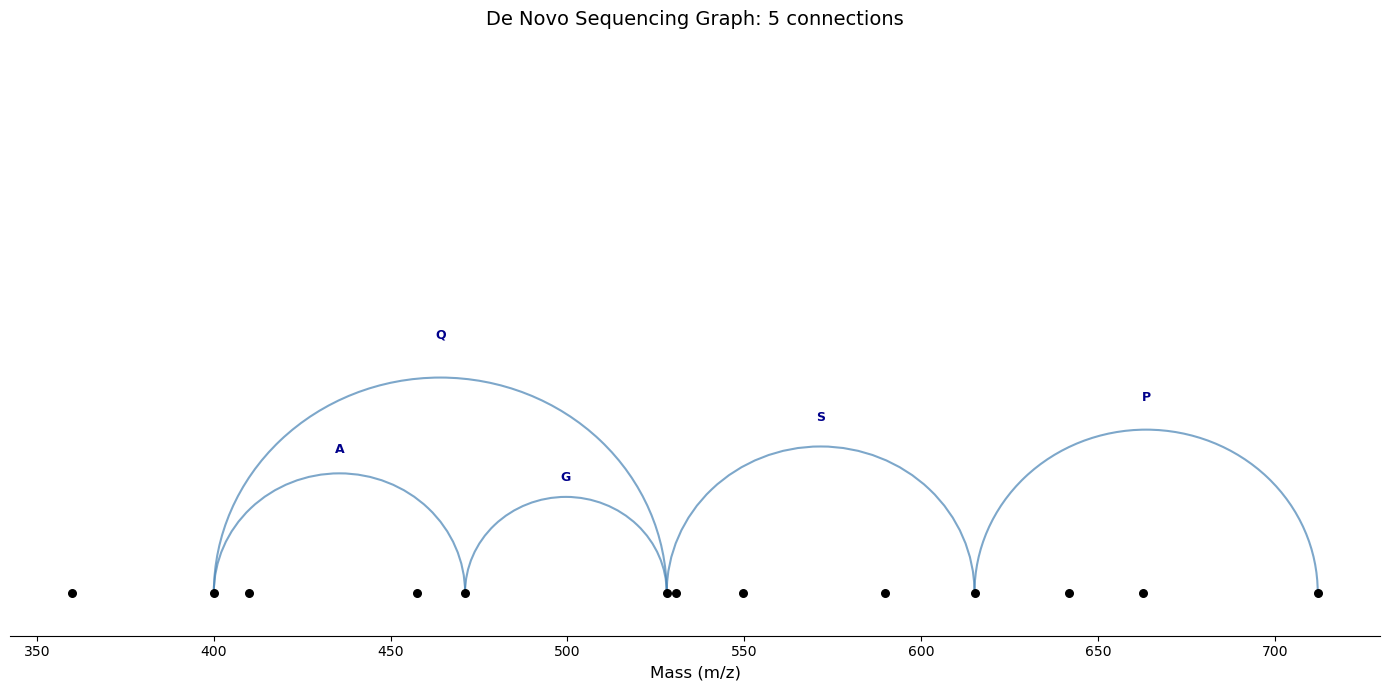

In [56]:
if __name__ == "__main__":
    # Create slightly more complex mock data
    seed = 400.0
    # A sequence: Ala - Gly - Ser - Pro
    seq_masses = [seed,
                  seed + AA_MASSES['A'],
                  seed + AA_MASSES['A'] + AA_MASSES['G'],
                  seed + AA_MASSES['A'] + AA_MASSES['G'] + AA_MASSES['S'],
                   seed + AA_MASSES['A'] + AA_MASSES['G'] + AA_MASSES['S'] + AA_MASSES['P']]

    # Add some noise
    np.random.seed(101)
    noise = np.random.uniform(350, 700, 8).tolist()
    my_peaks = sorted(seq_masses + noise)

    print(f"Simulated Peaks: {[round(p, 2) for p in my_peaks]}")

    # Find connections (slightly tighter tolerance for cleaner graph)
    conns = find_connections(my_peaks, tolerance=0.02)

    plot_labeled_arc_graph(my_peaks, conns)

In [57]:
data = 'ME4_2+'
csv_data = f"{data}.csv"
file_path = os.path.join(
    os.getcwd(),
    f"../data/Top_Correlations_At_Full_Num_Scans_PCov/annotated/{csv_data}"
)
file_path = os.path.abspath(file_path) 

## Store sequence into peptide class
sequence = util.name_ouput(csv_data)
pep = peptide.Pep(sequence)
the_length = len(pep.AA_array)
csv_data = file_path
df = pd.read_csv(csv_data)
df = df[df['Index'].notna()]
results = data_parse.process_ion_dataframe(df.head(50), pep)
results['classification'] = results.apply(data_parse.data_classify, args=(pep,), axis=1)
the_list = []
the_y_list = []

results['loss1'] = results['loss1'].replace({None: np.nan})
results['loss2'] = results['loss2'].replace({None: np.nan})


df = results

/Users/kevinmbp/Desktop/2D_spec_dict/vis_conserve/data_parse.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['y6', 'y5', 'y5', 'y4', 'y4', 'y6', 'y3', 'y3', 'y5', 'y2', 'y2', 'y3', 'y6', 'y4', 'y6', 'y5', 'y4']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_current.loc[df_current['type1'] == 'y', ['y_ion', 'y_mz']] = df_current.loc[df_current['type1'] == 'y', ['ion1', 'mass1']].values
/Users/kevinmbp/Desktop/2D_spec_dict/vis_conserve/data_parse.py:260: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['b4', 'b6', 'b6', 'a5', 'b5', 'bi(2-4)', 'bi(3-4)', 'b5', 'b5', 'b6', 'a6', 'b6', 'b3', 'a6', 'a4', 'bi(3-5)', 'b4', 'a4', 'a6', 'b5', 'bi(2-6)', 'a6', 'ai(3-5)']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_current.loc[df_cu

In [58]:
LETTER_ORDER = {ch: i for i, ch in enumerate("abcdefghijklmnopqrstuvwxyz")}
rows = ['Parent','(NH3)','(H2O)', '(NH3)-(H2O)','(H2O)-(NH3)', 'a', '2(H2O)', '2(NH3)']
conserve_line_mass_dict = {'Parent': pep.pep_mass, 'a': pep.pep_mass - 28.0106}
for i in rows:
    if i not in conserve_line_mass_dict:
        conserve_line_mass_dict[i] = pep.pep_mass - neutral_loss_mass.mass_of_loss(i)
print(conserve_line_mass_dict)

def classify_conserve_line(row):
    the_mass = row['chosen_sum']
    for i in conserve_line_mass_dict:
        if the_mass < conserve_line_mass_dict[i] + 1 and the_mass > conserve_line_mass_dict[i] - 1:
            return i
    else:
        return None

df['conserve_line'] = df.apply(classify_conserve_line, axis = 1)

{'Parent': 1525.7877099999998, 'a': 1497.7771099999998, '(NH3)': 1508.7611608988798, '(H2O)': 1507.7771453159698, '(NH3)-(H2O)': 1490.7505962148498, '(H2O)-(NH3)': 1490.7505962148498, '2(H2O)': 1489.7665806319399, '2(NH3)': 1491.7346117977597}


In [59]:
df_conserve = df[df['conserve_line'] == 'Parent']
df_conserve[['correct_mass1', 'correct_mass2']]

,correct_mass1,correct_mass2
0,508.20377,1017.58394
1,685.43549,840.35222
3,712.29364,813.49407
4,571.39256,954.39515
6,500.35545,1025.43226
10,565.22523,960.56248
11,387.27139,1138.51632
17,274.18733,1251.60038
25,345.14044,1180.64727


In [60]:
mass_list = list(df_conserve['correct_mass1']) + list(df_conserve['correct_mass2'])

In [61]:
mass_list = list(set(mass_list))
mass_list.sort()
mass_list

[274.18733000000003,
 345.14044,
 387.27139,
 500.35544999999996,
 508.20377,
 565.22523,
 571.39256,
 685.43549,
 712.29364,
 813.49407,
 840.35222,
 954.39515,
 960.5624799999999,
 1017.58394,
 1025.43226,
 1138.51632,
 1180.64727,
 1251.6003799999999]

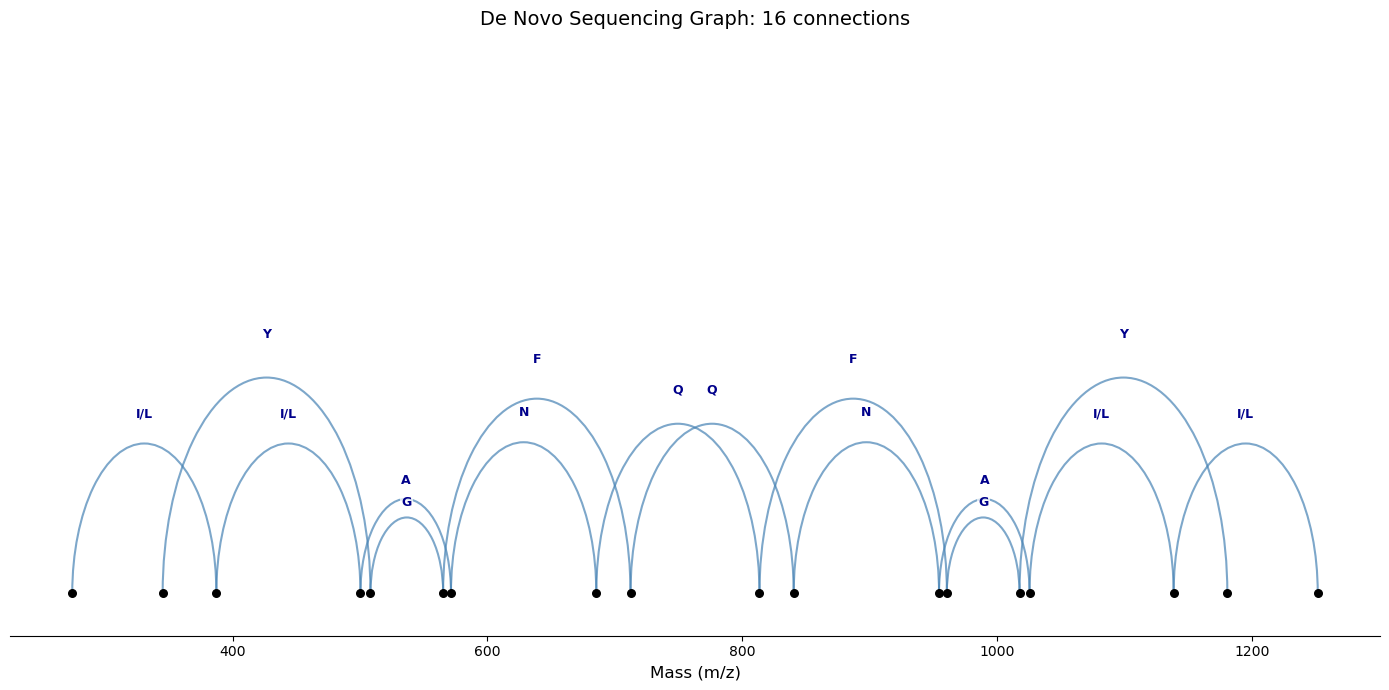

In [62]:
my_peaks = mass_list
my_connections = find_connections(my_peaks, tolerance=0.01)
plot_labeled_arc_graph(my_peaks, my_connections)

In [69]:
def find_all_connections(peaks, tolerance=0.02):
    """
    Identifies pairs of peaks separated by single AA mass OR double AA mass.
    Returns two separate lists of connections: (single_conns, double_conns)
    """
    peaks = sorted(peaks)
    single_conns = []
    double_conns = []

    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            mass_diff = peaks[j] - peaks[i]

            # Optimization: Stop if diff is too large for even the largest double (Trp+Trp ~ 372)
            if mass_diff > 400:
                break

            # 1. Check for Single AA matches
            for aa, aa_mass in AA_MASSES.items():
                if abs(mass_diff - aa_mass) <= tolerance:
                    single_conns.append((peaks[i], peaks[j], aa))

            # 2. Check for Double AA matches
            for label, double_mass in DOUBLE_AA_MASSES.items():
                 if abs(mass_diff - double_mass) <= tolerance:
                    double_conns.append((peaks[i], peaks[j], label))

    return single_conns, double_conns

In [95]:
def plot_complex_arc_graph(peaks, single_conns, double_conns):
    """
    Visualizes peaks with single AA arcs (above axis) and double AA arcs (below axis).
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot Nodes on the centerline (y=0)
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=40, zorder=5)
    
    num_peaks = len(peaks)
    for i, peak_mass in enumerate(peaks):
        # Check if the index is in the first 3 OR the last 3
        if i < 3 or i >= (num_peaks - 3):
            
            # Format the mass value (e.g., to 2 decimal places)
            label = f"{peak_mass:.2f}"
            
            # Place text just below the node
            ax.text(peak_mass, 0, label,
                    ha='right',  # Align the 'right' of the text to the peak
                    va='top',
                    fontsize=8,
                    color='#404040',
                    rotation=45, # Rotate 45 degrees
                    zorder=6)
    

    # Track max heights for scaling y-axis later
    # Initialize with small values to avoid errors if no connections found
    max_upper_height = 1.0
    max_lower_height = 1.0

    # --- Plot SINGLE connections (Above Axis, Positive Y) ---
    for start, end, label in single_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_upper_height = max(max_upper_height, height)

        # theta1=0, theta2=180 draws TOP half of ellipse/circle
        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color='steelblue', alpha=0.6, lw=1.5)
        ax.add_patch(arc)

        # Label above the arc peak
        ax.text(midpoint, (height / 2) + (width * 0.02), label,
                ha='center', va='bottom', fontsize=9, color='darkblue', weight='bold',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Plot DOUBLE connections (Below Axis, Negative Y) ---
    for start, end, label in double_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_lower_height = max(max_lower_height, height)

        # theta1=180, theta2=360 draws BOTTOM half
        # We use a different linestyle for distinction
        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=180, theta2=360, color='steelblue', alpha=0.5, lw=1.5, linestyle='--')
        ax.add_patch(arc)

        # Label below the arc peak (negative Y value)
        ax.text(midpoint, -(height / 2) - (width * 0.02), label,
                ha='center', va='top', fontsize=8, color='darkred', rotation=0,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Formatting ---
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3) # Faint centerline
    ax.set_xlabel("Mass (m/z)", fontsize=12)
    ax.set_yticks([]) # Turn off Y ticks
    for spine in ['top', 'right', 'left', 'bottom']:
         if spine == 'bottom':
             # Keep bottom spine visible but move it to y=0 if desired,
             # or just keep standard bottom spine for X-axis.
             pass
         else:
            ax.spines[spine].set_visible(False)

    # Important: Set Y limits to specifically show both upper and lower halves
    # Add ~20% padding for text labels
    ax.set_ylim(-(max_lower_height * 1.2), (max_upper_height * 1.2))

    # Set X limits with some padding around the data range
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    plt.title(f"Mass Spec Connectivity\nTop: Single AA ({len(single_conns)}) | Bottom: Double AA ({len(double_conns)})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [96]:
s_conns, d_conns = find_all_connections(my_peaks, tolerance=0.015)

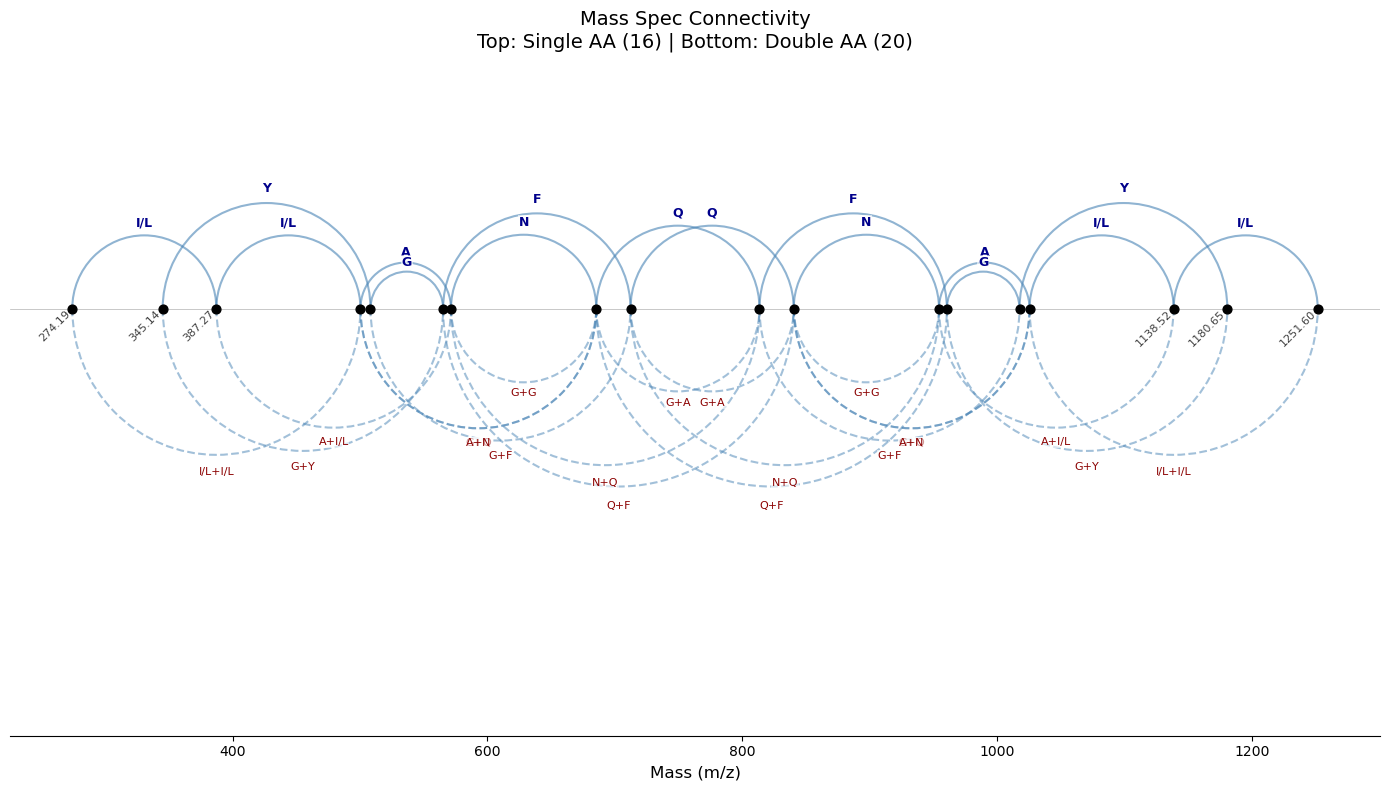

In [97]:
plot_complex_arc_graph(my_peaks, s_conns, d_conns)

In [78]:
nums = [-1,0,1,2,-1,-4]

In [79]:
nums.sort()
nums

[-4, -1, -1, 0, 1, 2]

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

def plot_complex_arc_graph(peaks, single_conns, double_conns, highlight_sequence=None):
    """
    Visualizes peaks with single AA arcs (above axis) and double AA arcs (below axis).
    Includes mass labels for each peak.
    
    Can optionally highlight all arcs whose labels are in 'highlight_sequence'.
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # --- NEW: Define colors and highlight set ---
    default_color = 'steelblue'
    highlight_color = 'crimson' # A bright red for high visibility

    # Create a lookup set for efficient checking
    highlight_set = set()
    if highlight_sequence is not None:
        highlight_set = set(highlight_sequence)
    # --- End of NEW section ---

    # Plot Nodes on the centerline (y=0)
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=40, zorder=5)
    
    # Annotate first 3 and last 3 peaks
    num_peaks = len(peaks)
    for i, peak_mass in enumerate(peaks):
        if i < 3 or i >= (num_peaks - 3):
            label = f"{peak_mass:.2f}"
            ax.text(peak_mass, 0, label,
                    ha='right', va='top', fontsize=8,
                    color='#404040', rotation=45, zorder=6)
    
    max_upper_height = 1.0
    max_lower_height = 1.0

    # --- Plot SINGLE connections (MODIFIED) ---
    for start, end, label in single_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_upper_height = max(max_upper_height, height)

        # --- NEW: Check for highlight ---
        is_highlighted = (label in highlight_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2      # Thicker line
            arc_zorder = 10   # Bring to front
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkblue'
            text_weight = 'bold'
        # --- End of NEW section ---

        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color=arc_color, alpha=0.7, 
                  lw=arc_lw, zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, (height / 2) + (width * 0.02), label,
                ha='center', va='bottom', fontsize=9, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Plot DOUBLE connections (MODIFIED) ---
    for start, end, label in double_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_lower_height = max(max_lower_height, height)

        # --- NEW: Check for highlight ---
        is_highlighted = (label in highlight_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2
            arc_zorder = 10
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkred'
            text_weight = 'normal' # Default weight
        # --- End of NEW section ---

        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=180, theta2=360, color=arc_color, alpha=0.5, 
                  lw=arc_lw, linestyle='--', zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, -(height / 2) - (width * 0.02), label,
                ha='center', va='top', fontsize=8, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Formatting (Unchanged) ---
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
    ax.set_xlabel("Mass (m/z)", fontsize=12)
    ax.set_yticks([]) 
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.set_ylim(-(max_lower_height * 1.2), (max_upper_height * 1.2))
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    plt.title(f"Mass Spec Connectivity\nTop: Single AA ({len(single_conns)}) | Bottom: Double AA ({len(double_conns)})", fontsize=14)
    plt.tight_layout()
    plt.show()

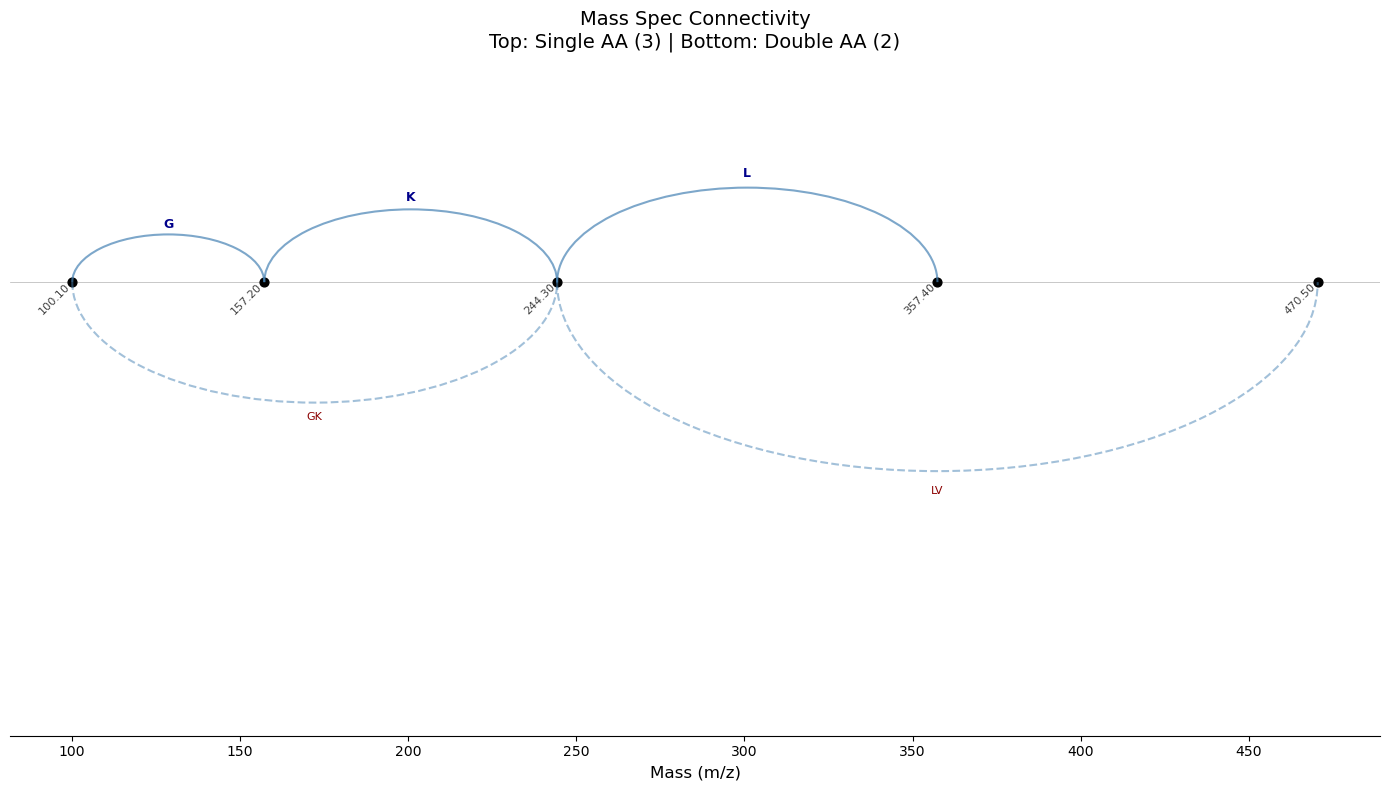

In [99]:
# Example Data
peaks = [100.1, 157.2, 244.3, 357.4, 470.5]
single = [(100.1, 157.2, 'G'), (157.2, 244.3, 'K'), (244.3, 357.4, 'L')]
double = [(100.1, 244.3, 'GK'), (244.3, 470.5, 'LV')]

# Call without the new argument
plot_complex_arc_graph(peaks, single, double)

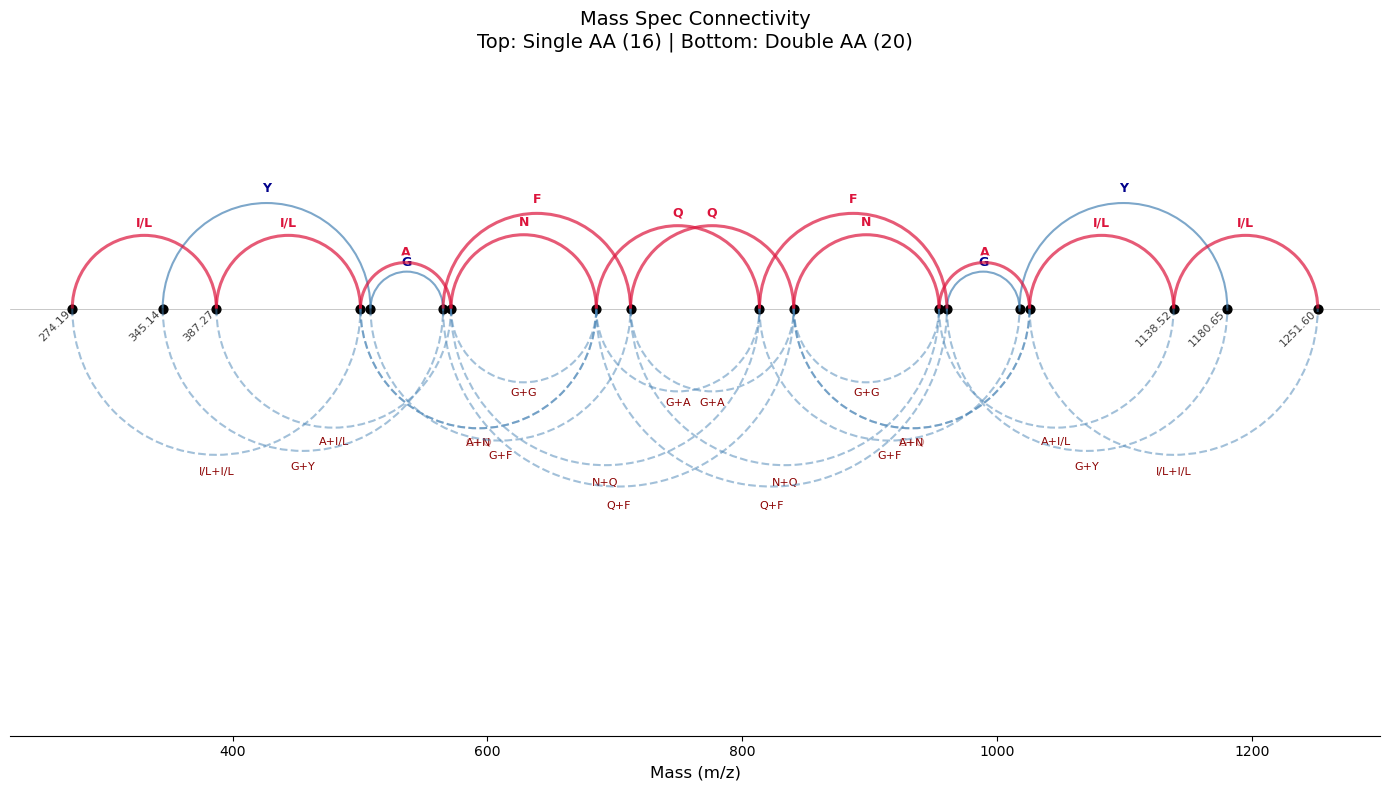

In [104]:
# Define the sequence you want to find
seq_to_find = ['I/L', 'I/L', 'A', 'N', 'Q', 'F'] 

# Call WITH the new argument
plot_complex_arc_graph(my_peaks, s_conns, d_conns, highlight_sequence=seq_to_find)

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

def plot_complex_arc_graph(peaks, single_conns, double_conns, highlight_sequence=None):
    """
    Visualizes peaks with single AA arcs (above axis) and double AA arcs (below axis).
    Includes mass labels for each peak.
    
    Can optionally highlight a specific sequence of arcs (path) based on the order
    of amino acids in 'highlight_sequence', assuming a left-to-right path.
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    default_color = 'steelblue'
    highlight_color = 'crimson'

    # --- NEW / MODIFIED: Pre-process highlight_sequence to identify specific arcs ---
    highlight_arc_set = set() # This set will store (start, end, label) for arcs to highlight
    if highlight_sequence is not None and len(highlight_sequence) > 0:
        # Create a mapping from (start, end, label) to arc type (single/double)
        # This is important because the labels can be the same but the connections different
        all_arcs_with_types = []
        for s, e, l in single_conns:
            all_arcs_with_types.append(((s, e, l), 'single'))
        for s, e, l in double_conns:
            all_arcs_with_types.append(((s, e, l), 'double'))
        
        # We need to link the 'peaks' (masses) to their positions in the graph
        # This will allow us to follow the path "from left to right"
        # Assuming 'peaks' are already sorted by mass (left to right)
        # If not, you might need to sort them or use their original indices.
        
        current_peak_index = 0
        # Iterate through possible starting peaks to find the full path
        for start_idx in range(len(peaks)):
            current_path_matched = []
            current_mass = peaks[start_idx]
            path_found = True

            for aa_label in highlight_sequence:
                # Look for an arc (single or double) that starts at current_mass
                # and has the amino acid label, and connects to the next peak.
                found_next_step = False
                for arc_tuple, arc_type in all_arcs_with_types:
                    arc_start, arc_end, arc_label = arc_tuple
                    # Check if the arc starts at our current mass, matches the label,
                    # and moves to a *greater* mass (left to right)
                    if np.isclose(arc_start, current_mass) and arc_label == aa_label and arc_end > current_mass:
                        current_path_matched.append(arc_tuple)
                        current_mass = arc_end
                        found_next_step = True
                        break # Found this step in the path, move to next AA
                
                if not found_next_step:
                    path_found = False
                    break # This path failed
            
            if path_found and len(current_path_matched) == len(highlight_sequence):
                # If a complete path is found, add all its arcs to the highlight set
                for arc_tuple in current_path_matched:
                    highlight_arc_set.add(arc_tuple)
                # We can choose to find only the first instance of the path, or all.
                # For "the path will always start from left to the right", finding the first
                # full path is usually sufficient unless there are multiple identical paths.
                # If multiple valid paths exist, this will highlight all of them.
    # --- End of NEW / MODIFIED section ---

    # Plot Nodes on the centerline (y=0)
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=40, zorder=5)
    
    num_peaks = len(peaks)
    for i, peak_mass in enumerate(peaks):
        if i < 3 or i >= (num_peaks - 3):
            label = f"{peak_mass:.2f}"
            ax.text(peak_mass, 0, label,
                    ha='right', va='top', fontsize=8,
                    color='#404040', rotation=45, zorder=6)
    
    max_upper_height = 1.0
    max_lower_height = 1.0

    # --- Plot SINGLE connections (MODIFIED to use highlight_arc_set) ---
    for start, end, label in single_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_upper_height = max(max_upper_height, height)

        # Check if THIS specific arc (start, end, label) is in our highlight_arc_set
        is_highlighted = ((start, end, label) in highlight_arc_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2
            arc_zorder = 10
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkblue'
            text_weight = 'bold'

        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color=arc_color, alpha=0.7, 
                  lw=arc_lw, zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, (height / 2) + (width * 0.02), label,
                ha='center', va='bottom', fontsize=9, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Plot DOUBLE connections (MODIFIED to use highlight_arc_set) ---
    for start, end, label in double_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_lower_height = max(max_lower_height, height)

        # Check if THIS specific arc (start, end, label) is in our highlight_arc_set
        is_highlighted = ((start, end, label) in highlight_arc_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2
            arc_zorder = 10
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkred'
            text_weight = 'normal'

        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=180, theta2=360, color=arc_color, alpha=0.5, 
                  lw=arc_lw, linestyle='--', zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, -(height / 2) - (width * 0.02), label,
                ha='center', va='top', fontsize=8, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Formatting (Unchanged) ---
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
    ax.set_xlabel("Mass (m/z)", fontsize=12)
    ax.set_yticks([]) 
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.set_ylim(-(max_lower_height * 1.2), (max_upper_height * 1.2))
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    plt.title(f"Mass Spec Connectivity\nTop: Single AA ({len(single_conns)}) | Bottom: Double AA ({len(double_conns)})", fontsize=14)
    plt.tight_layout()
    plt.show()

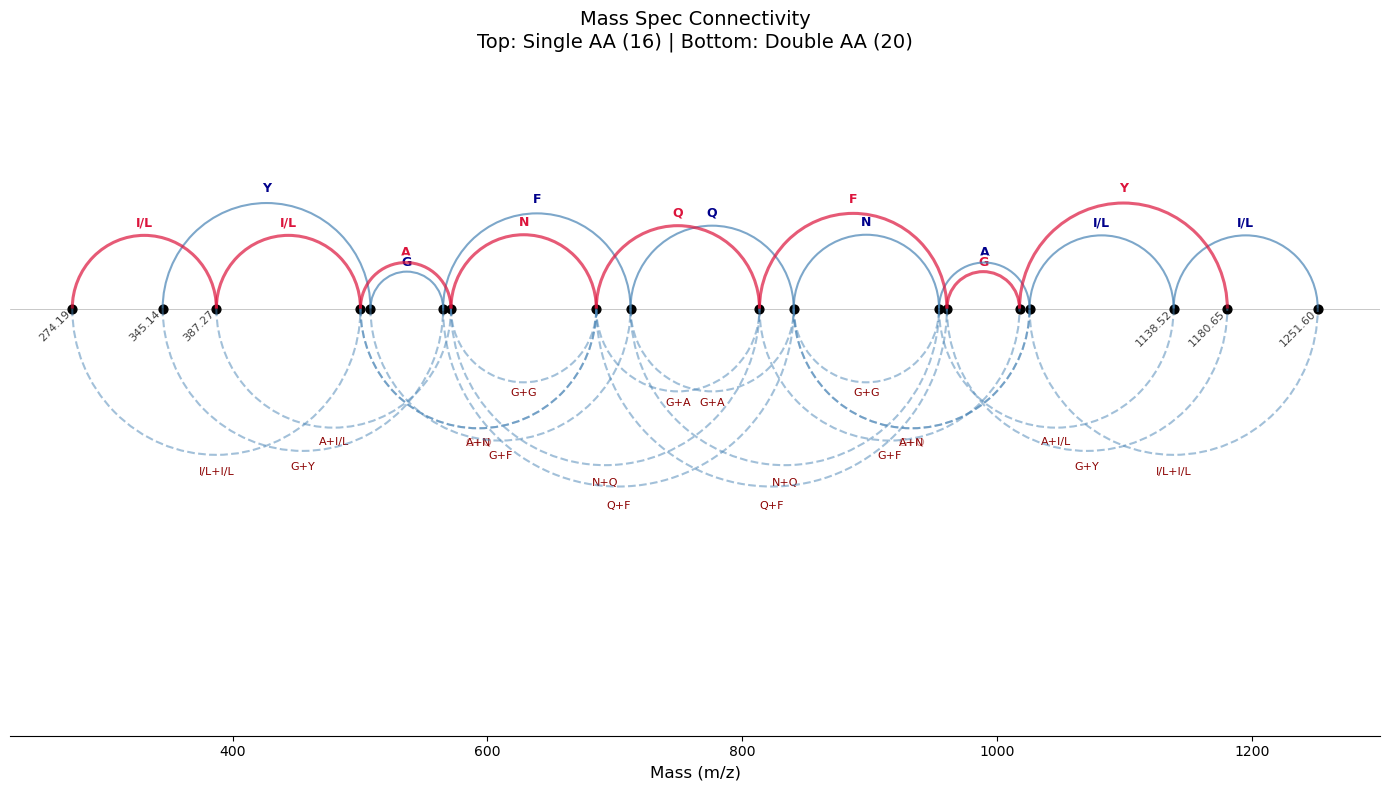

In [113]:
# Define the sequence you want to find
seq_to_find = ['I/L', 'I/L', 'A', 'N', 'Q', 'F', 'G', 'Y'] 

# Call WITH the new argument
plot_complex_arc_graph(my_peaks, s_conns, d_conns, highlight_sequence=seq_to_find)

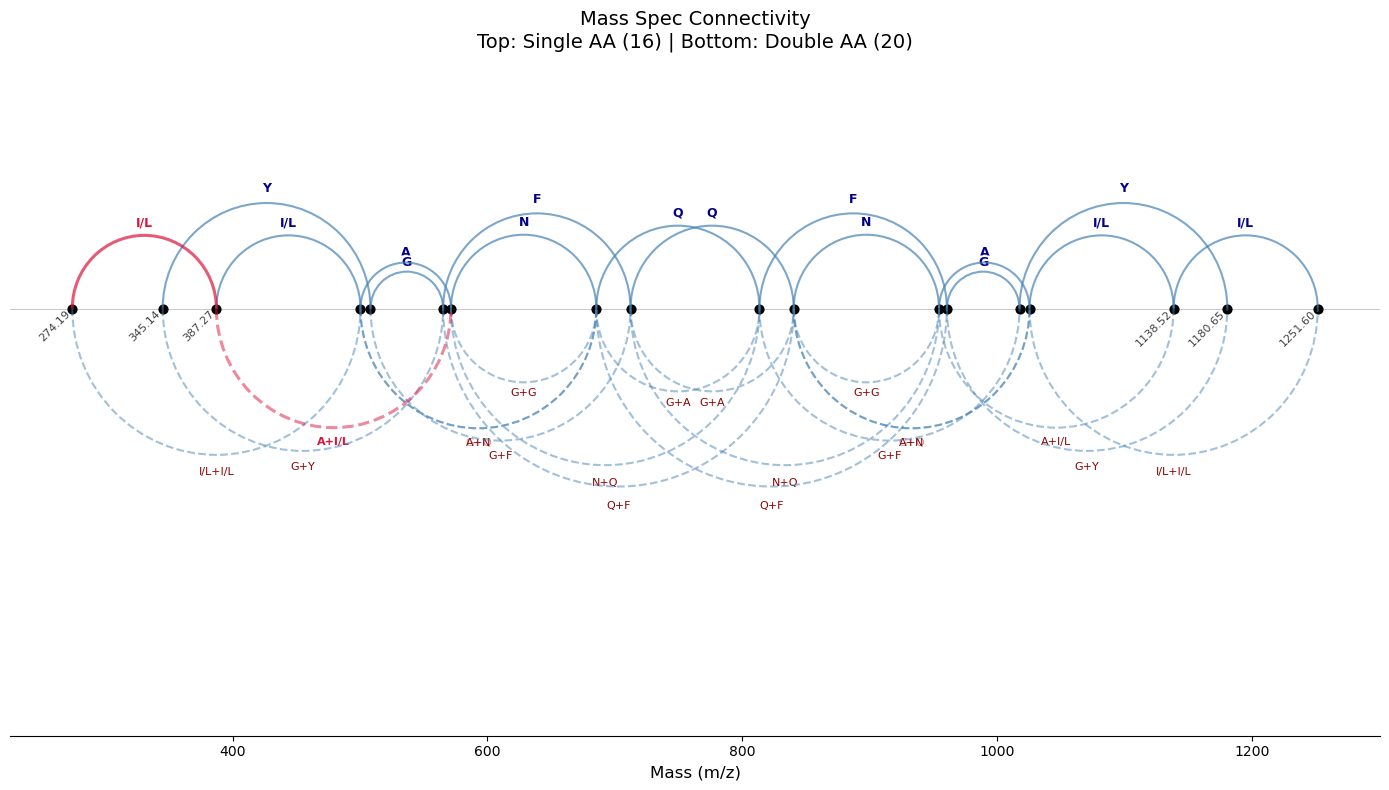

In [116]:
# Define the sequence you want to find
seq_to_find = ['I/L', 'A+I/L'] 

# Call WITH the new argument
plot_complex_arc_graph(my_peaks, s_conns, d_conns, highlight_sequence=seq_to_find)

In [1]:
501.36269999999996 - 387.27139

114.09130999999996

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

def plot_arc_graph(peaks, top_conns=None, bottom_conns=None, 
                   highlight_sequence=None, seq='', 
                   show_graph=True, save_path=False, 
                   top_label='Top', bottom_label='Bottom',
                   plot_title='Mass Spec Connectivity'):
    """
    Visualizes peaks with arcs above the axis (top_conns) and 
    arcs below the axis (bottom_conns).
    
    Can optionally highlight a specific sequence of arcs.
    """
    
    # CHANGED: Handle cases where no connections are provided
    if top_conns is None:
        top_conns = []
    if bottom_conns is None:
        bottom_conns = []

    fig, ax = plt.subplots(figsize=(14, 8))

    default_color = 'steelblue'
    highlight_color = 'crimson'

    # --- MODIFIED: Highlight logic now uses top_conns and bottom_conns ---
    highlight_arc_set = set()
    if highlight_sequence is not None and len(highlight_sequence) > 0:
        all_arcs_with_types = []
        
        # CHANGED: Use top_conns
        for s, e, l in top_conns:
            all_arcs_with_types.append(((s, e, l), 'top'))
        # CHANGED: Use bottom_conns
        for s, e, l in bottom_conns:
            all_arcs_with_types.append(((s, e, l), 'bottom'))
        
        # The rest of the highlight path-finding logic is the same
        for start_idx in range(len(peaks)):
            current_path_matched = []
            current_mass = peaks[start_idx]
            path_found = True

            for aa_label in highlight_sequence:
                found_next_step = False
                for arc_tuple, arc_type in all_arcs_with_types:
                    arc_start, arc_end, arc_label = arc_tuple
                    if np.isclose(arc_start, current_mass) and arc_label == aa_label and arc_end > current_mass:
                        current_path_matched.append(arc_tuple)
                        current_mass = arc_end
                        found_next_step = True
                        break 
                
                if not found_next_step:
                    path_found = False
                    break 
            
            if path_found and len(current_path_matched) == len(highlight_sequence):
                for arc_tuple in current_path_matched:
                    highlight_arc_set.add(arc_tuple)
    # --- End of MODIFIED highlight section ---

    # Plot Nodes on the centerline (y=0)
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=40, zorder=5)
    
    num_peaks = len(peaks)
    for i, peak_mass in enumerate(peaks):
        if i < 15 or i >= (num_peaks - 3):
            label = f"{peak_mass:.2f}"
            ax.text(peak_mass, 0, label,
                    ha='right', va='top', fontsize=8,
                    color='#404040', rotation=45, zorder=6)
    
    max_upper_height = 1.0
    max_lower_height = 1.0

    # --- Plot TOP connections (from top_conns) ---
    # CHANGED: Iterates over top_conns
    for start, end, label in top_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_upper_height = max(max_upper_height, height)

        is_highlighted = ((start, end, label) in highlight_arc_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2
            arc_zorder = 10
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkblue'
            text_weight = 'bold'

        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color=arc_color, alpha=0.7, 
                  lw=arc_lw, zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, (height / 2) + (width * 0.02), label,
                ha='center', va='bottom', fontsize=9, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Plot BOTTOM connections (from bottom_conns) ---
    # CHANGED: Iterates over bottom_conns
    for start, end, label in bottom_conns:
        midpoint = (start + end) / 2
        width = end - start
        height = width * 0.5
        max_lower_height = max(max_lower_height, height)

        is_highlighted = ((start, end, label) in highlight_arc_set)
        
        if is_highlighted:
            arc_color = highlight_color
            arc_lw = 2.2
            arc_zorder = 10
            text_color = highlight_color
            text_weight = 'extra bold'
        else:
            arc_color = default_color
            arc_lw = 1.5
            arc_zorder = 5
            text_color = 'darkred'
            text_weight = 'normal'

        # Note: Kept the dashed line style for the bottom arc
        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=180, theta2=360, color=arc_color, alpha=0.5, 
                  lw=arc_lw, linestyle='--', zorder=arc_zorder)
        ax.add_patch(arc)

        ax.text(midpoint, -(height / 2) - (width * 0.02), label,
                ha='center', va='top', fontsize=8, color=text_color, weight=text_weight,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5))

    # --- Formatting (Unchanged) ---
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
    ax.set_xlabel("Mass (m/z)", fontsize=12)
    ax.set_yticks([]) 
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.set_ylim(-(max_lower_height * 1.2), (max_upper_height * 1.2))
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    # --- CHANGED: Dynamic Title ---
    title_parts = []
    if top_conns:
        title_parts.append(f"{top_label}: {len(top_conns)}")
    if bottom_conns:
        title_parts.append(f"{bottom_label}: {len(bottom_conns)}")
    
    main_title_str = " | ".join(title_parts)
    if not main_title_str:
        main_title_str = "No Connections"

    plt.title(f"{plot_title}\n{main_title_str}\n{seq}", fontsize=14)
    # --- End of Title Change ---
    
    plt.tight_layout()
    if show_graph:
        plt.show()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    # It's good practice to close the figure if you're not in an
    # interactive environment, especially if calling this in a loop.
    if not show_graph:
        plt.close(fig)

In [3]:
# Example data (replace with your actual data)
# peaks = [100, 150, 200, 250, 300]
# single_conns = [(100, 200, 'A'), (150, 250, 'B')]
# double_conns = [(100, 300, 'C')]
# triple_conns = [(100, 250, 'X'), (200, 300, 'Y')]
# my_sequence = "A-B"
# my_seq_label = "My Sequence Label"

plot_arc_graph(
    peaks, 
    top_conns=single_conns, 
    bottom_conns=double_conns,
    highlight_sequence=my_sequence,
    seq=my_seq_label,
    top_label='Single AA',
    bottom_label='Double AA',
    plot_title='Single & Double AA Connectivity',
    save_path='graph_single_double.png'
)

NameError: name 'peaks' is not defined

In [4]:
AA_MASSES = {'A': 71.04, 'B': 103.01, 'C': 103.01, 'D': 115.03, 'E': 129.04, 'F': 147.07}
DOUBLE_AA_MASSES = {'A-A': 142.08, 'A-B': 174.05, 'B-C': 206.02, 'E-F': 276.11}
TRIPLE_AA_MASSES = {'A-A-A': 213.12, 'A-B-C': 277.06}

def find_all_connections(peaks, tolerance=0.005):
    """
    Identifies pairs of peaks separated by single, double, or triple AA mass.
    Returns three separate lists of connections.
    """
    peaks = sorted(peaks)
    single_conns = []
    double_conns = []
    triple_conns = []

    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            mass_diff = peaks[j] - peaks[i]

            # Optimization: Stop if diff is too large
            if mass_diff > 500: # Adjusted for triple
                break

            # 1. Check for Single AA matches
            for aa, aa_mass in AA_MASSES.items():
                if abs(mass_diff - aa_mass) <= tolerance:
                    single_conns.append((peaks[i], peaks[j], aa))

            # 2. Check for Double AA matches
            for label, double_mass in DOUBLE_AA_MASSES.items():
                 if abs(mass_diff - double_mass) <= tolerance:
                    double_conns.append((peaks[i], peaks[j], label))
            
            # 3. Check for Triple AA matches
            for label, triple_mass in TRIPLE_AA_MASSES.items():
                 if abs(mass_diff - triple_mass) <= tolerance:
                    triple_conns.append((peaks[i], peaks[j], label))

    return single_conns, double_conns, triple_conns

# --- NEW: Pathfinding Function ---

def find_all_paths(start_peak, all_connections):
    """
    Finds all possible paths (sequences of labels) starting from a given
    start_peak, using the provided connections.

    Args:
        start_peak (float): The exact mass of the peak to start from.
                            Must be one of the peaks used to generate connections.
        all_connections (list): A *combined* list of all connection tuples
                                [(start, end, label), ...] to be considered.

    Returns:
        list of lists: A list where each inner list is a path (sequence of labels).
                       e.g., [['A', 'B'], ['A', 'C', 'D']]
    """
    
    # --- Step 1: Build the adjacency list (graph_map) ---
    # This map makes it fast to look up all outgoing edges from any peak.
    graph_map = {}
    for start, end, label in all_connections:
        if start not in graph_map:
            graph_map[start] = []
        # Store the destination peak and the label of the edge
        graph_map[start].append((end, label))

    # --- Step 2: Define the recursive DFS helper function ---
    def dfs_recursive(current_peak, current_path):
        """
        Recursively explores paths from the current_peak.
        'current_path' holds the labels taken to get here.
        'found_paths' is populated by the outer function.
        """
        
        # Find all outgoing connections from the current peak
        outgoing_edges = graph_map.get(current_peak, [])

        # --- Base Case ---
        # If there are no outgoing edges, this is the end of a path.
        if not outgoing_edges:
            # If the path is not empty, save a *copy* of it.
            if current_path:
                found_paths.append(list(current_path))
            return # Stop recursion for this branch

        # --- Recursive Step ---
        # Explore each outgoing edge
        for next_peak, label in outgoing_edges:
            # 1. "Take" this path: Add the label
            current_path.append(label)
            
            # 2. Recurse: Explore from the next peak
            dfs_recursive(next_peak, current_path)
            
            # 3. "Backtrack": Remove the label so the loop can
            #    explore the *next* outgoing edge from 'current_peak'.
            current_path.pop()

    # --- Step 3: Start the search ---
    found_paths = []
    # Call the recursive helper starting from the 'start_peak' with an empty path
    dfs_recursive(start_peak, [])
    
    return found_paths

# --- Example Usage ---

if __name__ == "__main__":
    # 1. Define our peaks
    #    (100) --A(71.04)--> (171.04) --B(103.01)--> (274.05)
    #      |                                          |
    #      +--------A-B(174.05)----------------------+
    #      |
    #      +--------A-B-C(277.06)---------------------------> (377.06)
    
    peaks_list = [100.0, 171.04, 274.05, 377.06]
    
    # 2. Find all connections
    s_conns, d_conns, t_conns = find_all_connections(peaks_list, tolerance=0.01)
    
    print("--- Connections Found ---")
    print(f"Single: {s_conns}")
    print(f"Double: {d_conns}")
    print(f"Triple: {t_conns}")
    print("-" * 25)

    # 3. Combine the connections you want to search.
    #    For this example, we'll search all of them.
    all_conns = s_conns + d_conns + t_conns
    
    # 4. Define your starting point
    start_from_peak = 100.0
    
    # 5. Find all paths
    all_paths = find_all_paths(start_from_peak, all_conns)
    
    print(f"\n--- Paths found starting from {start_from_peak} ---")
    if all_paths:
        for i, path in enumerate(all_paths):
            print(f"Path {i+1}: {' -> '.join(path)}")
    else:
        print("No paths found from this starting peak.")

    # --- Example 2: Starting from a different peak ---
    start_from_peak_2 = 171.04
    all_paths_2 = find_all_paths(start_from_peak_2, all_conns)
    
    print(f"\n--- Paths found starting from {start_from_peak_2} ---")
    if all_paths_2:
        for i, path in enumerate(all_paths_2):
            print(f"Path {i+1}: {' -> '.join(path)}")
    else:
        print("No paths found from this starting peak.")

--- Connections Found ---
Single: [(100.0, 171.04, 'A'), (171.04, 274.05, 'B'), (171.04, 274.05, 'C'), (274.05, 377.06, 'B'), (274.05, 377.06, 'C')]
Double: [(100.0, 274.05, 'A-B'), (171.04, 377.06, 'B-C')]
Triple: [(100.0, 377.06, 'A-B-C')]
-------------------------

--- Paths found starting from 100.0 ---
Path 1: A -> B -> B
Path 2: A -> B -> C
Path 3: A -> C -> B
Path 4: A -> C -> C
Path 5: A -> B-C
Path 6: A-B -> B
Path 7: A-B -> C
Path 8: A-B-C

--- Paths found starting from 171.04 ---
Path 1: B -> B
Path 2: B -> C
Path 3: C -> B
Path 4: C -> C
Path 5: B-C
